## Introduction to Data Science

## The CRISP-DM approach to Data Science Tasks

_________________________

## I. Business Understanding
                    
#### The Business Understanding phase focuses on understanding the objectives and requirements of the project.  
+ **Determine business objectives**:   Construir um detector de fake news.
+ **Assess situation**:  A detecção de fake news já faz parte do subconsciente do usuário diário da internet. Felizmente podemos traduzir nossa intuição por trás de um título duvidoso e de palavras no imperativo para termos de Machine Learing. 
+ **Determine data mining goals** :  Buscar por sites de notícias que analisam veracidade de notícias, extraindo URLs, manchetes, subtítulos e outras informações pertinentes.
+ **Produce project plan** :  
Avaliar fontes de coleta de dados.
Selecionar critério para confiabilidade de um site.
Coletar e limpar os dados.
Construir e examinar modelo Tfidf.
Averiguar os resultados e reavaliar o modelo.
Revisar o projeto e realizar o deploy.





## II. Data Understanding  

+ Collect initial data:  
+ Describe data:  
+ Explore data:  
+ Verify data quality:  

### Metas!!!

+ Organizar categorias de notícias e os veículos de transmissão
+ Encontrar pessoas/instiuições/temas recorrentes
+ Atentar para caracteres Unicode
+ Determinar filtros (o que vamos armazenar do texto fonte).

# Pacotes usados para a primeira metade do projeto

In [1]:
#### Basic ####

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Web Tools ####

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

import requests
import urllib
from bs4 import BeautifulSoup as bs

import time

#### Textual Analysis ####

import codecs
import string
import re
from collections import Counter
from collections import defaultdict

import nltk
from wordcloud import WordCloud


In [2]:
datapath  = "../data"
datapath2 = "../data_2"
datapath3 = "../data_3"

class_name_error = "erro-wrapper"
class_name_label = "etiqueta"
url = 'https://piaui.folha.uol.com.br/lupa/tag/verificamos/'


labels = ['VERDADEIRO','VERDADEIRO, MAS','AINDA É CEDO PARA DIZER','EXAGERADO',
          'CONTRADITÓRIO','SUBESTIMADO','FALSO','DE OLHO']


## Scrapping setup

In [3]:
# Verificar situação do site
url = 'https://piaui.folha.uol.com.br/lupa/tag/verificamos/'
content = requests.get(url)
print(content.status_code)

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


200


### Funções auxiliares para acessar o HTML da página

In [4]:
def check_block(bloco):
    # Verifica se o bloco começa com #Verificamos, indicando que é noticia de 
    # verificação
    try:
        title = bloco.find_element_by_class_name("bloco-title")
    except:
        return False
    
    verificamos = re.search("\#Verificamos",title.text)
    
    if verificamos is None:
        return False
    else:
        return True

def extract_link(bloco):
    # Extrai link do bloco que leva a notícia
    return bloco.find_element_by_tag_name("a").get_attribute("href")


def extract_title(texto):
    # Substituído na versão local.
    # provavelmente a função não será mais utilizada
    
    regex = r'Confira.*\n.*(?<=“)(.*)(?=”)'
    
    match = re.search(regex, texto)
    
    if match is None:
        return None
    
    return match.group(1)



def page_out_of_bounds(driver):
    #Critério de parada para o scrapping, caso acabem as noticias.
    
    penguin = driver.find_elements_by_class_name(class_name_error)
    
    if len(penguin) == 0:
        return False
    else:
        return True
    
def extract_date_and_type(bloco):
    
    #Extrai a data e o tipo da notícia.
    
    info = bloco.find_element_by_class_name('bloco-meta').text
    regex = r'(\d{2}\.\d{2}\.\d{4}).\|.*\|.(.*)'
    
    match = re.search(regex,info)
    date = match.group(1)
    tipo = match.group(2)
    
    return (date,tipo)
    
    

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:7: DeprecationWarning: invalid escape sequence \#
<>:7: DeprecationWarning: invalid escape sequence \#
<ipython-input-4-bffbf014f4fd>:7: DeprecationWarning: invalid escape sequence \#
  verificamos = re.search("\#Verificamos",title.text)


# Prepare * not * to scrape!
Mudamos o modo de extrair informação do texto
## Mas inicie os drivers!!!!


In [ ]:
options = webdriver.chrome.options.Options()
options.headless = True

driver  = webdriver.Chrome(ChromeDriverManager().install(), options = options)
crawler = webdriver.Chrome(ChromeDriverManager().install(), options = options)

In [55]:
df = pd.DataFrame(columns = ['titulo_original', 'label', 'noticia_completa','veiculo', 'data_publicacao'],
                  dtype= 'string')

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
N = 160
index = 0
while True:
    
    page = url + 'page/' + str(N)
    
    driver.get(page)
    
    if page_out_of_bounds(driver):
        break
    blocos = driver.find_elements_by_class_name('bloco')
    
    for bloco in blocos:
        
        if check_block(bloco):
            
        
            link = extract_link(bloco)
            date_tipo = extract_date_and_type(bloco)
            
            crawler.get(link)
            label = crawler.find_element_by_class_name(class_name_label).text
            completo = crawler.find_element_by_class_name("post-inner")
            noticia_completa = completo.text
            noticia_original = extract_title(noticia_completa)
            
            df.loc[index] = [noticia_original,label,noticia_completa ,date_tipo[1],date_tipo[0]]
            index += 1

    N += 1


/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

## Local storage

All your data are belong to us


Rodar célula apenas uma vez

In [15]:
# Algumas marcas de python barato, mas deixa aí por enquanto

N = 0
i = 0
while True:
    
    page = url + 'page/' + str(N)
    
    driver.get(page)
    
    if page_out_of_bounds(driver):
        break
    blocos = driver.find_elements_by_class_name('bloco')
    
    for bloco in blocos:
        
        if check_block(bloco):
            
        
            link = extract_link(bloco)
            date_tipo = extract_date_and_type(bloco)
            
            crawler.get(link)
            completo = crawler.find_element_by_class_name("post-inner")
            noticia_completa = completo.text
            
            path = datapath + f'/lupa_{i}'
            i += 1
            
            date_str = f'{date_tipo[0]}  {date_tipo[1]}'
            
            with open(path, 'w') as f:
                f.write(date_str + '\n' + noticia_completa)
            
               
            

    N += 1


print('Done!!!')

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Done!!!


Com o local storage:


Criar uma string com todos as noticias completas.

In [3]:
texts = ''

for filename in os.listdir(datapath3):
    filepath = datapath3 + f'/{filename}'
    
    with open(filepath, 'r') as f:
        texts += f.read()
        texts += '\n'

    
len(texts)    


5141305

Caso não tenha o nltk em pt

In [7]:
nltk.download('stopwords')

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /home/isaque/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
stopwords = nltk.corpus.stopwords.words('portuguese')

uol_freqwords = ['circula', 'lupa', 'verificação', 'editado', 'sobre',
                'assine', 'confira', 'lente', 'newsletter', 'gratuita',
                'texto', 'vídeo', 'notícias', 'meio', 'projeto', 
                'imagem', 'seguir', 'analisada', 'analisado', 'trabalho',
                'dia', 'material', 'sido', 'ser', 'solicitaram', 
                '\u200cde\u200c', '\u200co\u200c','–', 'segundo', 'reportagem']

list_words = texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation) for l in list_words]
list_words = [l for l in list_words if l not in stopwords]
list_words = [l for l in list_words if l not in uol_freqwords]

freqdist = Counter(list_words)
freqdist.most_common(20)

[('facebook', 6712),
 ('redes', 2409),
 ('sociais', 2332),
 ('falso', 2329),
 ('informação', 2247),
 ('pessoas', 1968),
 ('covid-19', 1749),
 ('bolsonaro', 1692),
 ('usuários', 1677),
 ('nota', 1627),
 ('mil', 1625),
 ('falsa', 1597),
 ('presidente', 1550),
 ('federal', 1308),
 ('brasil', 1291),
 ('parte', 1250),
 ('contra', 1247),
 ('2020', 1189),
 ('governo', 1164),
 ('foto', 1155)]

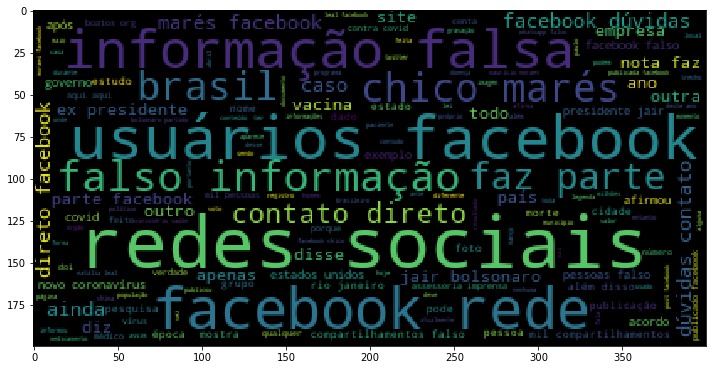

In [5]:
cleaned = ' '.join(list_words)
wordcloud = WordCloud().generate(cleaned)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

In [6]:
print(freqdist.get('bolsonaro'))
print(freqdist.get('lula'))
print(freqdist.get('trump'))
print(freqdist.get('doria'))

1692
737
207
203


Remover "Assine a lupa"

In [4]:
propaganda = 'Assine a Lente, a newsletter gratuita sobre desinformação da Lupa!'

for filename in os.listdir(datapath):
    filepath = datapath + f'/{filename}'
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    filepath2 = f'../data_2/{filename}'
    
    with open(filepath2, 'w') as f:
        for line in lines:
            if line.strip('\n') != propaganda:
                f.write(line)
    
        

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Remover "Nota:"

In [6]:
nota = r'Nota:‌ ‌esta‌ ‌reporta.*'
verif = r'Esta‌ ‌verificação ‌foi sugerid.*'

for filename in os.listdir(datapath):
    filepath = datapath + f'/{filename}'
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    filepath2 = f'../data_2/{filename}'
    
    with open(filepath2, 'w') as f:
        for line in lines:
            match1 = re.match(nota,line)
            match2 = re.match(verif,line)
            if (match1 is None) and (match2 is None):
                f.write(line)
    

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Regularizar aspas:

In [12]:
for filename in os.listdir(datapath2):
    
    filepath2 = datapath2 + f'/{filename}'
    
    with open(filepath2,'r') as f:     
        lines = f.readlines()
        
    
    filepath3 = f'../data_3/{filename}'
    
    with open(filepath3, 'w') as f:
        for line in lines:
            f.write(line.replace('“','"').replace('”','"'))

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
teste = 'Vacina provoca surto de poliomielite no Sudão'
teste.replace('“','"').replace('”','"')

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Vacina provoca surto de poliomielite no Sudão'

## III. Data Preparation

+ Select data:   
+ Clean data:   
+ Construct data/transform data/feature engineering:   
+ Integrate data:   
+ (Re) Format data:   

Após o local storage, queremos extrair a notícia pelo arquivo de texto bruto.

### Exploração teste, não rode a célula abaixo


In [6]:
labels = [r'VERDADEIRO',r'VERDADEIRO, MAS',r'AINDA É CEDO PARA DIZER',r'EXAGERADO',
          r'CONTRADITÓRIO',r'SUBESTIMADO',r'FALSO',r'DE OLHO']

exp = r'(?<=“(.*)(?=”)'

false = 0
not_false = 0

N_matches = 0
for filename in os.listdir(datapath2):
    filepath = datapath2 + f'/{filename}'

    print(20*'-')
    print(f'File {filepath}')
    print(20*'-')

    with open(filepath, 'r') as f:
        text = f.read()
    with open(filepath, 'r') as f:
        lines = f.readlines()
        
        
    for line in lines:
        x = line.strip('\n')
        if x in labels:
            print(line)
            if x == 'FALSO':
                false += 1
            else:
                not_false += 1

    match1 = re.findall(exp, text)

    if match1 is not None:
        N_matches += 1
        Max = ''
        for i in match1:
            if len(i) > len(Max):
                Max = i
        print(Max)


    print(20*'*')

print(f'Numero de matches = {N_matches}')
print(false)
print(not_false)
        

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--------------------
File ../data_2/lupa_42
--------------------
FALSO

O áudio que narra a situação chegou até o grupo [Tirol] com a característica [marcação] ‘encaminhado com frequência’, o que geralmente é uma marca das fake news
********************
--------------------
File ../data_2/lupa_1198
--------------------
FALSO

FALSO

Manifestantes gritam ‘Globo Lixo’ e exigem o impeachment de Gilmar Mendes em São Paulo – Av. Paulista
********************
--------------------
File ../data_2/lupa_16
--------------------
FALSO

In Brazil, embattled President Jair Bolsonaro this month rallied supporters in demonstrations that more than 150 critics, including former heads of state, said in an open letter were “modeled on the insurrection” at the U.S. Capitol”, escreveu o jornal. Em tradução livre: “No Brasil, o presidente Jair Bolsonaro reuniu simpatizantes em manifestações em que mais de 150 críticos, incluindo ex-chefes de Estado, disseram em carta aberta terem sido ‘modeladas na insurreiç

FALSO

FALSO

O documento continua revelando que mulheres vacinadas que estão grávidas podem sofrer abortos espontâneos e outros problemas reprodutivos – e pessoas não vacinadas que entram em contato com elas também podem. As mães vacinadas também podem passar o que quer que esteja contido na injeção Pfizer para seus bebês através do leite materno contaminado
********************
--------------------
File ../data_2/lupa_1116
--------------------
FALSO

Centro do Rio. Olhem que loucura
********************
--------------------
File ../data_2/lupa_827
--------------------
FALSO


********************
--------------------
File ../data_2/lupa_1727
--------------------
FALSO

[Bolsonaro] É um cara que eu confio mesmo. É um cara que trabalha como você, que luta como você, que erra como você e aprende com seus erros, como você
********************
--------------------
File ../data_2/lupa_1517
--------------------
FALSO

FALSO

FALSO

FALSO

[Honduras] é o país com maior taxa de homicídios
***

FALSO

FALSO

(…) [Santa Catarina] Tem hoje a menor taxa de assassinatos
********************
--------------------
File ../data_2/lupa_790
--------------------
FALSO

explosão de casos na China
********************
--------------------
File ../data_2/lupa_1613
--------------------
EXAGERADO

FALSO

FALSO

FALSO

Tornado em Foz do Iguaçu na tarde de hoje, 13.12.2018
********************
--------------------
File ../data_2/lupa_169
--------------------
FALSO

novas evidências clínicas relacionadas ao uso de hidroxicloroquina em indivíduos infectados com SARS-CoV-2 indicaram um risco aumentado de reações adversas em face de poucos ou nenhum benefício
********************
--------------------
File ../data_2/lupa_1688
--------------------
FALSO

criação de um painel artístico de difusão cultural nos segmentos da música, dança e artes cênicas, dentro e fora do espaço físico do Club A São Paulo
********************
--------------------
File ../data_2/lupa_646
--------------------
FALSO

Maior

FALSO

jornalista da Band News vai revelar uma bomba do governo Bolsonaro que vai abalar as estruturas do país
********************
--------------------
File ../data_2/lupa_1511
--------------------
FALSO

Na foto, Élcio, que executou Marielle Franco junto com Ronnie, parece descontraído ao lado de Eduardo e Jair Bolsonaro
********************
--------------------
File ../data_2/lupa_365
--------------------
EXAGERADO

FALSO

Apesar das tendências encorajadoras demonstradas nas bases de dados, não temos ainda evidência suficientemente robusta para justificar o uso ou a aprovação regulatória da ivermectina [contra a Covid-19]. Contudo, a falta de evidência de alta qualidade apenas destaca a necessidade clara de estudos clínicos adicionais, com maior qualidade e escala, para investigar o uso da ivermectina com mais profundidade
********************
--------------------
File ../data_2/lupa_1188
--------------------
FALSO

jogam a culpa [de tudo] em cima do diabo.” “Acho fantástico isso. V

FALSO

Coaf na cola: Assinatura de Bolsonaro aparece em livro de ouro dos porteiros do condomínio onde mora
********************
--------------------
File ../data_2/lupa_1067
--------------------
FALSO

embora fosse um desejo dele” e que, quando assumiu o cargo, o estado estava falido e era necessário, primeiro, “reverter essa situação
********************
--------------------
File ../data_2/lupa_1093
--------------------
algumas horas”, e dependem de uma determinada taxa de umidade e uma determinada temperatura para sobreviver. Mesmo em líquidos, é improvável que sobrevivam mais do que alguns dias. Para um dos infectologistas citados, o risco de transmissão é zero. Outro disse que essa suspeita é “absolutamente sem fundamento” e contribui para a “histeria coletiva
********************
--------------------
File ../data_2/lupa_503
--------------------
FALSO

FALSO

FALSO

Era para liberar um remédio que atenua os efeitos da quimioterapia e eles [os diretores] não liberaram
*************

In [7]:
#Precisamos de uma função para pegar todos os textos.

def investigate(lines):
    
    pos = []
    for i in range(len(lines)):
        if lines[i].strip('\n') in labels:
            pos.append(i)
    
    N = 0
    combo = []
    for i in pos:
        
        cur = i-2
        if i-2 > -1:
            while N != 2:
                count = lines[cur].count('"')
                N += count
                
                if N >= 2:
                    N = N % 2
                
                if not N:
                    if lines[cur][0] == '"':
                        text = ''
                        for j in range(cur,i-1):
                            text += lines[j]
                        combo.append((lines[i], text))
                        N = 2
                
                
                        
                cur -= 1
                if cur < 0:
                    N = 2
                
                
            N = 0
    
    primeira = lines[0]
    
    dia = primeira[0:10]
    tipo = primeira[15:]
    
    return combo, dia, tipo
                                
            
        
    


In [8]:
dic = {'titulo':[], 'data':[], 'tipo':[], 'label':[]}
df = pd.DataFrame(dic)

In [9]:
for filename in os.listdir('../data_3'):
    
    filepath3 = f'../data_3/{filename}'
    
    with open(filepath3,'r') as f:     
        lines = f.readlines()
        
    
    combo,dia, tipo = investigate(lines)
    for i in combo:  
        dic = {'titulo':i[1], 'data':dia, 'tipo':tipo, 'label':i[0]}
        df = df.append(dic, ignore_index=True)
    

In [10]:
df

,titulo,data,tipo,label
0,"""NÃO COMPRE PRODUTOS\nESSA EMPRESA ""PROIBE"" O ...",06.09.2021,FACEBOOK\n,FALSO\n
1,"""Ao vivo Avenida Paulista lotada em protesto c...",18.11.2019,FACEBOOK\n,FALSO\n
2,"""Manifestantes gritam ‘Globo Lixo’ e exigem o ...",18.11.2019,FACEBOOK\n,FALSO\n
3,"""Bolsonaro is the best brazilian president of ...",27.09.2021,FACEBOOK\n,FALSO\n
4,"""Essa é a jornalista Patrícia Campos Mello, qu...",27.10.2018,FACEBOOK\n,FALSO\n
...,...,...,...,...
2150,"""ATENÇÃO‼️‼️☝️ OLHA QUE CURIOSO – Justamente A...",07.05.2020,FACEBOOK\n,FALSO\n
2151,"""Pra galera que ta aí dizendo que ""socorreria ...",10.12.2019,FACEBOOK\n,FALSO\n
2152,"""Ninguém de máscaras!""\n",05.01.2021,FACEBOOK\n,FALSO\n
2153,"""Lula vaiado agora dia 16/08/21 em um restaura...",17.08.2021,WHATSAPP\n,FALSO\n


In [11]:
df2 = df.replace(r'\n','', regex=True) 

In [12]:
df2

,titulo,data,tipo,label
0,"""NÃO COMPRE PRODUTOSESSA EMPRESA ""PROIBE"" O US...",06.09.2021,FACEBOOK,FALSO
1,"""Ao vivo Avenida Paulista lotada em protesto c...",18.11.2019,FACEBOOK,FALSO
2,"""Manifestantes gritam ‘Globo Lixo’ e exigem o ...",18.11.2019,FACEBOOK,FALSO
3,"""Bolsonaro is the best brazilian president of ...",27.09.2021,FACEBOOK,FALSO
4,"""Essa é a jornalista Patrícia Campos Mello, qu...",27.10.2018,FACEBOOK,FALSO
...,...,...,...,...
2150,"""ATENÇÃO‼️‼️☝️ OLHA QUE CURIOSO – Justamente A...",07.05.2020,FACEBOOK,FALSO
2151,"""Pra galera que ta aí dizendo que ""socorreria ...",10.12.2019,FACEBOOK,FALSO
2152,"""Ninguém de máscaras!""",05.01.2021,FACEBOOK,FALSO
2153,"""Lula vaiado agora dia 16/08/21 em um restaura...",17.08.2021,WHATSAPP,FALSO


Build dataframe

In [58]:
df2.to_pickle('../myDataFrame')

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
df2.describe()

,titulo,data,tipo,label
count,2155,2155,2155,2155
unique,2127,755,7,6
top,"""Resumo das manifestações.PT/PCO = BateuPSDB =...",17.04.2019,FACEBOOK,FALSO
freq,5,32,1817,1990


In [14]:
pd.unique(df2['tipo'])

array(['FACEBOOK', 'WHATSAPP', 'IÇÕES 2018', 'S', 'DO', 'PAAQUI',
       'IÇÕES 2020'], dtype=object)

In [15]:
df3 = df2[(df2['tipo'] == 'FACEBOOK') | (df2['tipo'] == 'WHATSAPP')]
df3

,titulo,data,tipo,label
0,"""NÃO COMPRE PRODUTOSESSA EMPRESA ""PROIBE"" O US...",06.09.2021,FACEBOOK,FALSO
1,"""Ao vivo Avenida Paulista lotada em protesto c...",18.11.2019,FACEBOOK,FALSO
2,"""Manifestantes gritam ‘Globo Lixo’ e exigem o ...",18.11.2019,FACEBOOK,FALSO
3,"""Bolsonaro is the best brazilian president of ...",27.09.2021,FACEBOOK,FALSO
4,"""Essa é a jornalista Patrícia Campos Mello, qu...",27.10.2018,FACEBOOK,FALSO
...,...,...,...,...
2150,"""ATENÇÃO‼️‼️☝️ OLHA QUE CURIOSO – Justamente A...",07.05.2020,FACEBOOK,FALSO
2151,"""Pra galera que ta aí dizendo que ""socorreria ...",10.12.2019,FACEBOOK,FALSO
2152,"""Ninguém de máscaras!""",05.01.2021,FACEBOOK,FALSO
2153,"""Lula vaiado agora dia 16/08/21 em um restaura...",17.08.2021,WHATSAPP,FALSO


In [16]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2095 entries, 0 to 2154
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   titulo  2095 non-null   object
 1   data    2095 non-null   object
 2   tipo    2095 non-null   object
 3   label   2095 non-null   object
dtypes: object(4)
memory usage: 81.8+ KB


In [17]:
df3[df3['tipo'] == 'FACEBOOK']

,titulo,data,tipo,label
0,"""NÃO COMPRE PRODUTOSESSA EMPRESA ""PROIBE"" O US...",06.09.2021,FACEBOOK,FALSO
1,"""Ao vivo Avenida Paulista lotada em protesto c...",18.11.2019,FACEBOOK,FALSO
2,"""Manifestantes gritam ‘Globo Lixo’ e exigem o ...",18.11.2019,FACEBOOK,FALSO
3,"""Bolsonaro is the best brazilian president of ...",27.09.2021,FACEBOOK,FALSO
4,"""Essa é a jornalista Patrícia Campos Mello, qu...",27.10.2018,FACEBOOK,FALSO
...,...,...,...,...
2149,"""Só no Brasil um meliante preso em flagrante c...",02.10.2019,FACEBOOK,FALSO
2150,"""ATENÇÃO‼️‼️☝️ OLHA QUE CURIOSO – Justamente A...",07.05.2020,FACEBOOK,FALSO
2151,"""Pra galera que ta aí dizendo que ""socorreria ...",10.12.2019,FACEBOOK,FALSO
2152,"""Ninguém de máscaras!""",05.01.2021,FACEBOOK,FALSO


In [18]:
df3['label'].value_counts()

FALSO                      1943
EXAGERADO                    51
VERDADEIRO                   49
VERDADEIRO, MAS              38
AINDA É CEDO PARA DIZER      11
DE OLHO                       3
Name: label, dtype: int64

In [19]:
import unidecode

df_clean = df3
df_clean['target'] = df_clean['label'] == 'FALSO'
df_clean['facebook'] = df_clean['tipo'] == 'FACEBOOK'


<ipython-input-19-65feaafb82bd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['target'] = df_clean['label'] == 'FALSO'
<ipython-input-19-65feaafb82bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['facebook'] = df_clean['tipo'] == 'FACEBOOK'


In [20]:
df_clean['facebook'].value_counts()

True     1817
False     278
Name: facebook, dtype: int64

In [21]:
df_clean

,titulo,data,tipo,label,target,facebook
0,"""NÃO COMPRE PRODUTOSESSA EMPRESA ""PROIBE"" O US...",06.09.2021,FACEBOOK,FALSO,True,True
1,"""Ao vivo Avenida Paulista lotada em protesto c...",18.11.2019,FACEBOOK,FALSO,True,True
2,"""Manifestantes gritam ‘Globo Lixo’ e exigem o ...",18.11.2019,FACEBOOK,FALSO,True,True
3,"""Bolsonaro is the best brazilian president of ...",27.09.2021,FACEBOOK,FALSO,True,True
4,"""Essa é a jornalista Patrícia Campos Mello, qu...",27.10.2018,FACEBOOK,FALSO,True,True
...,...,...,...,...,...,...
2150,"""ATENÇÃO‼️‼️☝️ OLHA QUE CURIOSO – Justamente A...",07.05.2020,FACEBOOK,FALSO,True,True
2151,"""Pra galera que ta aí dizendo que ""socorreria ...",10.12.2019,FACEBOOK,FALSO,True,True
2152,"""Ninguém de máscaras!""",05.01.2021,FACEBOOK,FALSO,True,True
2153,"""Lula vaiado agora dia 16/08/21 em um restaura...",17.08.2021,WHATSAPP,FALSO,True,False


Remover pontuação e melhorar o formato do texto

In [130]:
def tira_pontuacao(texto):
    
    new_text = [char for char in texto if char not in string.punctuation]
    new_text = ''.join(new_text)
    return new_text

df_clean['limpo'] = df_clean['titulo'].apply(tira_pontuacao)

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-130-3ddfc9b7f750>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['limpo'] = df_clean['titulo'].apply(tira_pontuacao)


In [131]:
df_clean

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,titulo,data,tipo,label,target,whatsapp,facebook,limpo
0,NÃO COMPRE PRODUTOSESSA EMPRESA PROIBE O USO D...,06.09.2021,FACEBOOK,FALSO,True,False,True,NÃO COMPRE PRODUTOSESSA EMPRESA PROIBE O USO D...
1,Ao vivo Avenida Paulista lotada em protesto co...,18.11.2019,FACEBOOK,FALSO,True,False,True,Ao vivo Avenida Paulista lotada em protesto co...
2,Manifestantes gritam ‘Globo Lixo’ e exigem o i...,18.11.2019,FACEBOOK,FALSO,True,False,True,Manifestantes gritam ‘Globo Lixo’ e exigem o i...
3,Bolsonaro is the best brazilian president of a...,27.09.2021,FACEBOOK,FALSO,True,False,True,Bolsonaro is the best brazilian president of a...
4,Essa é a jornalista Patrícia Campos Mello que ...,27.10.2018,FACEBOOK,FALSO,True,False,True,Essa é a jornalista Patrícia Campos Mello que ...
...,...,...,...,...,...,...,...,...
2150,ATENÇÃO‼️‼️☝️ OLHA QUE CURIOSO – Justamente Ag...,07.05.2020,FACEBOOK,FALSO,True,False,True,ATENÇÃO‼️‼️☝️ OLHA QUE CURIOSO – Justamente Ag...
2151,Pra galera que ta aí dizendo que socorreria o ...,10.12.2019,FACEBOOK,FALSO,True,False,True,Pra galera que ta aí dizendo que socorreria o ...
2152,Ninguém de máscaras,05.01.2021,FACEBOOK,FALSO,True,False,True,Ninguém de máscaras
2153,Lula vaiado agora dia 160821 em um restaurante...,17.08.2021,WHATSAPP,FALSO,True,True,False,Lula vaiado agora dia 160821 em um restaurante...


In [132]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

df_clean['limpo'] = df_clean['limpo'].apply(remove_emoji)

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-132-2ac8fdbdd28b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['limpo'] = df_clean['limpo'].apply(remove_emoji)


In [133]:
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

df_clean['limpo'] = df_clean['limpo'].apply(remove_number)

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-133-2a4b7d1a5d3e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['limpo'] = df_clean['limpo'].apply(remove_number)


In [139]:
def remove_acentos(text):
    new_text = unidecode.unidecode(text)
    return new_text

df_clean['limpo'] = df_clean['limpo'].apply(remove_acentos)

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-139-3d3c67fc81d0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['limpo'] = df_clean['limpo'].apply(remove_acentos)


In [140]:
df_clean

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,titulo,data,tipo,label,target,whatsapp,facebook,limpo
0,NÃO COMPRE PRODUTOSESSA EMPRESA PROIBE O USO D...,06.09.2021,FACEBOOK,FALSO,True,False,True,NAO COMPRE PRODUTOSESSA EMPRESA PROIBE O USO D...
1,Ao vivo Avenida Paulista lotada em protesto co...,18.11.2019,FACEBOOK,FALSO,True,False,True,Ao vivo Avenida Paulista lotada em protesto co...
2,Manifestantes gritam ‘Globo Lixo’ e exigem o i...,18.11.2019,FACEBOOK,FALSO,True,False,True,Manifestantes gritam 'Globo Lixo' e exigem o i...
3,Bolsonaro is the best brazilian president of a...,27.09.2021,FACEBOOK,FALSO,True,False,True,Bolsonaro is the best brazilian president of a...
4,Essa é a jornalista Patrícia Campos Mello que ...,27.10.2018,FACEBOOK,FALSO,True,False,True,Essa e a jornalista Patricia Campos Mello que ...
...,...,...,...,...,...,...,...,...
2150,ATENÇÃO‼️‼️☝️ OLHA QUE CURIOSO – Justamente Ag...,07.05.2020,FACEBOOK,FALSO,True,False,True,ATENCAO!!EMOJI!!EMOJI OLHA QUE CURIOSO - Justa...
2151,Pra galera que ta aí dizendo que socorreria o ...,10.12.2019,FACEBOOK,FALSO,True,False,True,Pra galera que ta ai dizendo que socorreria o ...
2152,Ninguém de máscaras,05.01.2021,FACEBOOK,FALSO,True,False,True,Ninguem de mascaras
2153,Lula vaiado agora dia 160821 em um restaurante...,17.08.2021,WHATSAPP,FALSO,True,True,False,Lula vaiado agora dia NUMBER em um restaurante...


In [141]:
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text


df_clean['limpo'] = df_clean['limpo'].apply(remove_not_ASCII)

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-141-23fac2ec7e68>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['limpo'] = df_clean['limpo'].apply(remove_not_ASCII)


In [144]:
def remove_stopwords(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('portuguese')]
    return remove_stopword

df_clean['limpo'] = df_clean['limpo'].apply(remove_stopwords)  

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-144-9df2f72c2e1b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['limpo'] = df_clean['limpo'].apply(remove_stopwords)


In [145]:
df_clean

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,titulo,data,tipo,label,target,whatsapp,facebook,limpo
0,NÃO COMPRE PRODUTOSESSA EMPRESA PROIBE O USO D...,06.09.2021,FACEBOOK,FALSO,True,False,True,"[NAO, COMPRE, PRODUTOSESSA, EMPRESA, PROIBE, U..."
1,Ao vivo Avenida Paulista lotada em protesto co...,18.11.2019,FACEBOOK,FALSO,True,False,True,"[vivo, Avenida, Paulista, lotada, protesto, co..."
2,Manifestantes gritam ‘Globo Lixo’ e exigem o i...,18.11.2019,FACEBOOK,FALSO,True,False,True,"[Manifestantes, gritam, 'Globo, Lixo', exigem,..."
3,Bolsonaro is the best brazilian president of a...,27.09.2021,FACEBOOK,FALSO,True,False,True,"[Bolsonaro, is, the, best, brazilian, presiden..."
4,Essa é a jornalista Patrícia Campos Mello que ...,27.10.2018,FACEBOOK,FALSO,True,False,True,"[jornalista, Patricia, Campos, Mello, fez, mat..."
...,...,...,...,...,...,...,...,...
2150,ATENÇÃO‼️‼️☝️ OLHA QUE CURIOSO – Justamente Ag...,07.05.2020,FACEBOOK,FALSO,True,False,True,"[ATENCAO!!EMOJI!!EMOJI, OLHA, CURIOSO, -, Just..."
2151,Pra galera que ta aí dizendo que socorreria o ...,10.12.2019,FACEBOOK,FALSO,True,False,True,"[Pra, galera, ta, ai, dizendo, socorreria, pol..."
2152,Ninguém de máscaras,05.01.2021,FACEBOOK,FALSO,True,False,True,"[Ninguem, mascaras]"
2153,Lula vaiado agora dia 160821 em um restaurante...,17.08.2021,WHATSAPP,FALSO,True,True,False,"[Lula, vaiado, agora, dia, NUMBER, restaurante..."


## IV. Modeling

+ Select modeling techniques: 
+ Generate test design: 
+ Build model: 
+ Assess model:  

Novos imports para modeling

In [88]:
#nltk só p/ garantir
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS


#Test-train
from sklearn.model_selection import train_test_split


#Tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout


#Avaliar o modelo
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/isaque/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/isaque/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself.

In [146]:
train_data = df_clean

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [147]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['limpo'].values)
X = tokenizer.texts_to_sequences(train_data['limpo'].values)
X = pad_sequences(X)

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [148]:
X.shape

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2095, 430)

In [149]:
y = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101)

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [150]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 430, 32)           96000     
_________________________________________________________________
dropout (Dropout)            (None, 430, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [154]:
y_pred = model.predict(X_test).round()

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [151]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/10
53/53 [==============================] - 15s 240ms/step - loss: 0.3412 - accuracy: 0.9218 - val_loss: 0.2697 - val_accuracy: 0.9236
Epoch 2/10
53/53 [==============================] - 16s 300ms/step - loss: 0.2555 - accuracy: 0.9284 - val_loss: 0.2733 - val_accuracy: 0.9236
Epoch 3/10
53/53 [==============================] - 18s 338ms/step - loss: 0.2440 - accuracy: 0.9284 - val_loss: 0.2601 - val_accuracy: 0.9236
Epoch 4/10
53/53 [==============================] - 18s 334ms/step - loss: 0.1796 - accuracy: 0.9296 - val_loss: 0.2375 - val_accuracy: 0.9260
Epoch 5/10
53/53 [==============================] - 18s 332ms/step - loss: 0.0820 - accuracy: 0.9690 - val_loss: 0.3064 - val_accuracy: 0.9141
Epoch 6/10
53/53 [==============================] - 17s 326ms/step - loss: 0.0460 - accuracy: 0.9857 - val_loss: 0.3409 - val_accuracy: 0.9069
Epoch 7/10
53/53 [==============================] - 19s 365ms/step - loss: 0.0284 - accuracy: 0.9934 - val_loss: 0.4480 - val_accuracy: 0.9236

In [152]:
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100

In [155]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))


Accuracy  is  :  0.9116945107398569
Recall  is    :  0.9819121447028424
Precision  is :  0.926829268292683


/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [156]:
conm = confusion_matrix(y_test,y_pred)
conm

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[  2,  30],
       [  7, 380]])

/home/isaque/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


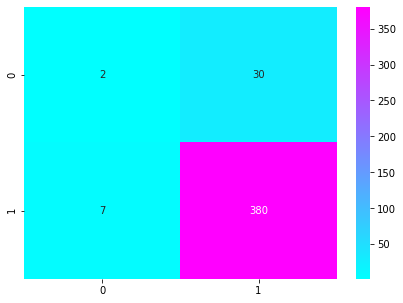

In [157]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

## V. Evaluation                    

+ Evaluate results: 
+ Review process: 
+ Determine next steps: 

## VI. Deployment

+ Plan deployment: 
+ Plan monitoring and maintenance: 
+ Produce final report: 
+ Review project: 